In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from datetime import datetime
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score,precision_score, recall_score, f1_score,mean_absolute_error, mean_squared_error,precision_recall_curve

import sklearn.metrics

import missingno as msno
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
from sqlalchemy import create_engine
# engine = create_engine('postgresql://postgres@localhost:5432/pec')
#df = pd.read_sql_query('select * from pec_mod',con=engine)
#df = pd.read_csv('output/data_trans_out.xlsx', header=0,sheet_name='Sheet1')
df = pd.read_csv('output/pec_prep_out.csv')
df=df.drop([ "Unnamed: 0"], axis=1)

In [3]:
df.columns

Index(['Compagnie d'assurance', 'Date de création',
       'Nom et Prénom Assuré /Raison Sociale',
       'Immatriculation Véhicule assuré', 'Mode de gestion',
       'Garantie impliquée', 'Chargé réparation', 'Marque', 'Réparateur',
       'Expert', 'Compagnie adverse', 'Accord VR (Véhicule de remplacement)',
       'Agence', 'Agent', 'Cas de barème', 'Chargé acceptation', 'Code agence',
       'Date Accident', 'Date acceptation', 'Date accord (SST)',
       'Date demande', 'Etape Dossier', 'Etat d'approbation',
       'Immatriculation tiers', 'Montant total devis',
       'Nom et Prénom tiers /Raison Sociale', 'Numero sinistre',
       'Numéro de contrat', 'Point Choc', 'Position GA', 'SST',
       'Nbr réclamations antérieures', 'Jour Accident', 'Mois Accident',
       'Année Accident', 'Jour demande', 'Mois demande', 'Année demande',
       'Retard reclamation', 'Fraud'],
      dtype='object')

In [4]:
# dropping uninformative features
colsToDelete = ['Année demande','Année Accident','Nom et Prénom Assuré /Raison Sociale',
       'Immatriculation Véhicule assuré','Nom et Prénom tiers /Raison Sociale','Immatriculation tiers', 
       'Numero sinistre', 'Numéro de contrat','Date de création','Date Accident','Date acceptation','Date accord (SST)' ,'Date demande']
df = df.drop(columns = colsToDelete, axis=1)
df.head()

,Compagnie d'assurance,Mode de gestion,Garantie impliquée,Chargé réparation,Marque,Réparateur,Expert,Compagnie adverse,Accord VR (Véhicule de remplacement),Agence,Agent,Cas de barème,Chargé acceptation,Code agence,Etape Dossier,Etat d'approbation,Montant total devis,Point Choc,Position GA,SST,Nbr réclamations antérieures,Jour Accident,Mois Accident,Jour demande,Mois demande,Retard reclamation,Fraud
0,EL AMANA TAKAFUL,IDA,Défense et recours,Asma TURKI,ISUZU,MECATOL,Hadiji Yassine,MAE,NON,global assurance,global assurance,10.0,Ouni Hela,744,Véhicule réparé: en instance de Signature du BS,Approuvé ( Chef cellule Acceptation ),914.604,"Tiers Ar. D,Tiers Lat. D",Recours,Fathi Nguili,2,31,3,4,4,4,Non
1,LA CARTE,Dommages,Dommages au véhicule,,ALFA ROMEO,NaN,NaN,ASSURANCES STAR,NaN,mohamed boussaa,mohamed boussaa,9.0,Ouni Hela,780,En instance d'établissement Devis,Approuvé ( Chef cellule Acceptation ),NaN,Tiers Ar. D,Recours,,1,4,12,9,12,5,Non
2,LLOYD TUNISIEN,Dommages,Tierce collision,Asma TURKI,KIA,SPEED SERVICES,Salah BEN HASSINE,BIAT assurances,NON,sondos ayoub,sondos ayoub,15.0,Ouni Hela,658,Véhicule réparé: en instance de Signature du BS,Approuvé ( Chef cellule Acceptation ),1790.491,Tiers Lat. D,Recours,Tayssir HMAIED,1,21,5,24,5,3,Non
3,LLOYD TUNISIEN,Dommages,Tierce collision,Ouni Dhekra,VOLKSWAGEN,Société EL-FATAH,Hadiji Yassine,LLOYD TUNISIEN,NON,wajih laamiri,wajih laamiri,NaN,Ouni Hela,776,Véhicule réparé: en instance de Signature du BS,Approuvé ( Chef cellule Acceptation ),2468.064,Tiers Ar. D,Défense,Fathi Nguili,1,30,3,5,4,6,Non
4,LLOYD TUNISIEN,Dommages,Tierce collision,Ouni Dhekra,VOLKSWAGEN,Société EL-FATAH,Amara Ayari,GAT assurances,OUI,aisaoui fathi,aisaoui fathi,10.0,Ouni Hela,685,Véhicule réparé: en instance de Signature du BS,Approuvé ( Chef cellule Acceptation ),2972.116,Tiers Av. G,Recours,Fathi Nguili,1,7,4,15,4,8,Non


In [5]:
df.shape

(1097, 27)

In [8]:
threshold = 0.97
# calculate correlations
corr_matrix = df.corr().abs()
# get the upper part of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# columns with correlation above threshold
redundent = [column for column in upper.columns if any(upper[column] >= threshold)]
print(f'Columns to drop with correlation > {threshold}: {redundent}')
# df.drop(columns=redundent, inplace=True)

Columns to drop with correlation > 0.97: ['Mois demande']


In [9]:
df.columns

Index(['Compagnie d'assurance', 'Mode de gestion', 'Garantie impliquée',
       'Chargé réparation', 'Marque', 'Réparateur', 'Expert',
       'Compagnie adverse', 'Accord VR (Véhicule de remplacement)', 'Agence',
       'Agent', 'Cas de barème', 'Chargé acceptation', 'Code agence',
       'Etape Dossier', 'Etat d'approbation', 'Montant total devis',
       'Point Choc', 'Position GA', 'SST', 'Nbr réclamations antérieures',
       'Jour Accident', 'Mois Accident', 'Jour demande', 'Mois demande',
       'Retard reclamation', 'Fraud'],
      dtype='object')

In [10]:
# separate the target column from the features
y = df["Fraud"].map({"Non":0, "Oui":1})
X = df.drop("Fraud", axis=1)

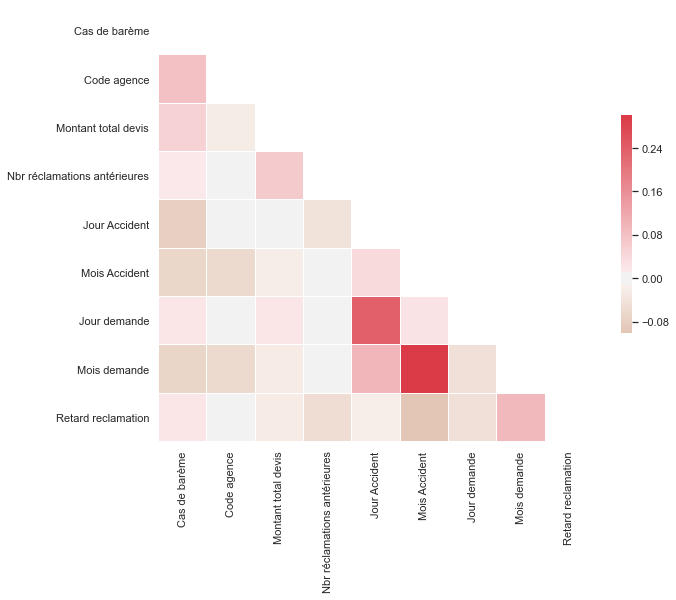

In [11]:

#Correlation in the dataset
corr = X.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(style="white")

f, ax = plt.subplots(figsize=(10, 8))
cmap = sns.diverging_palette(30, 10, as_cmap=True)
snsplot=sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.1, cbar_kws={"shrink": .5});
fig = snsplot.get_figure()
fig.savefig("figure_EDA/Corr.png") 

In [12]:
from sklearn.preprocessing import LabelEncoder
for i in  (X.columns):
    le = LabelEncoder()
    le.fit(X[i].astype(str))
    X[i] = le.transform(X[i].astype(str))
X=X

In [13]:
# train test split data
testsize=0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=0)

In [14]:
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
# prepare configuration for cross validation test harness
kfold = model_selection.KFold(n_splits=30, random_state=7)

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC(probability=True)))
models.append(('ADA', AdaBoostClassifier()))
models.append(('XGB', XGBClassifier()))
models.append(('MLP', MLPClassifier()))

LR: 0.653029
KNN: 0.502882
DT: 0.547284
RF: 0.696598
SVM: 0.545582
ADA: 0.679050
XGB: 0.709649
MLP: 0.616172


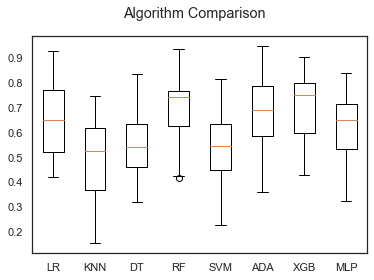

In [15]:
results = []
names = []
scoring = 'roc_auc_ovo'
for name, model in models:
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     cv_results = accuracy_score(y_test, y_pred)
    results.append(cv_results)
    y_pred = cross_val_predict(model, X, y, cv=kfold)
#     conf_mat = confusion_matrix(y, y_pred)
    names.append(name)
    msg = "%s: %f" % (name, cv_results.mean())
    print(msg)
#     print(conf_mat)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.savefig('figure_EDA/algo_comp_accuracy.png',dpi=400,bbox_inches='tight')
plt.show()

LR: 0.795785
KNN: 0.779808
DT: 0.706973
RF: 0.798314
SVM: 0.804981
ADA: 0.779885
XGB: 0.797011
MLP: 0.767241


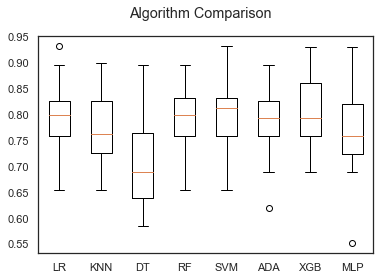

In [19]:
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     cv_results = accuracy_score(y_test, y_pred)
    results.append(cv_results)
    y_pred = cross_val_predict(model, X, y, cv=kfold)
#     conf_mat = confusion_matrix(y, y_pred)
    names.append(name)
    msg = "%s: %f" % (name, cv_results.mean())
    print(msg)
#     print(conf_mat)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.savefig('figure_EDA/algo_comp_accuracy.png',dpi=400,bbox_inches='tight')
plt.show()

LR: 0.663584
KNN: 0.502573
DT: 0.545812
RF: 0.681451
SVM: 0.610665
ADA: 0.677527
XGB: 0.702786
MLP: 0.647175


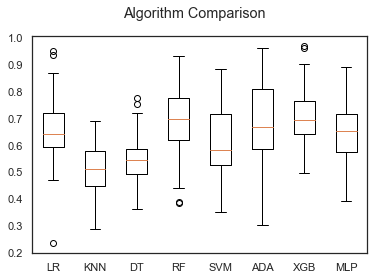

In [20]:
results = []
names = []
scoring = 'roc_auc'
for name, model in models:
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     cv_results = roc_auc_score(y_test, y_pred)
    results.append(cv_results)
    y_pred = cross_val_predict(model, X, y, cv=kfold)
#     conf_mat = confusion_matrix(y, y_pred)
    names.append(name)
    msg = "%s: %f" % (name, cv_results.mean())
    print(msg)
#     print(conf_mat)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.savefig('figure_EDA/algo_comp_f1.png',dpi=400,bbox_inches='tight')
plt.show()